## Combining data from multiple sensors

This notebook describes how to load data for multiple sensors and concatenate the results to generate a multi sensor time series

In [16]:
%pylab notebook
import datacube
import xarray as xr
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [17]:
dc = datacube.Datacube(app='combining data from multiple sensors')

In [18]:
#### DEFINE SPATIOTEMPORAL RANGE AND BANDS OF INTEREST
#Use this to manually define an upper left/lower right coords


#Define temporal range
start_of_epoch = '1998-01-01'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = [#'blue',
                     #'green',
                     'red', 
                     #'nir',
                     #'swir1', 
                     #'swir2'
                     ]

#Define sensors of interest
sensors = ['ls8', 'ls7', 'ls5'] 

query = {'time': (start_of_epoch, end_of_epoch)}
lat_max = -17.42
lat_min = -17.45
lon_max = 140.90522
lon_min = 140.8785

query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [19]:
print query

{'y': (-17.42, -17.45), 'x': (140.8785, 140.90522), 'crs': 'EPSG:4326', 'time': ('1998-01-01', '2016-12-31')}


# retrieve the NBAR and PQ for the spatiotemporal range of interest


In [20]:
#Define which pixel quality artefacts you want removed from the results
mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [21]:
#Retrieve the NBAR and PQ data for sensor n
sensor_clean = {}
for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', fuse_func=pq_fuser, **query)
    #grab the projection info before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    #This line is to make sure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    #Apply the PQ masks to the NBAR
    cloud_free = masking.make_mask(sensor_pq, **mask_components)
    good_data = cloud_free.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar = sensor_nbar.where(good_data)
    sensor_clean[sensor] = sensor_nbar

In [22]:
sensor_clean['ls5']

<xarray.Dataset>
Dimensions:  (time: 327, x: 124, y: 141)
Coordinates:
  * time     (time) datetime64[ns] 1998-01-12 1998-02-04 1998-02-20 ...
  * y        (y) float64 -1.891e+06 -1.891e+06 -1.891e+06 -1.891e+06 ...
  * x        (x) float64 9.437e+05 9.438e+05 9.438e+05 9.438e+05 9.438e+05 ...
Data variables:
    red      (time, y, x) float64 725.0 590.0 508.0 563.0 617.0 644.0 617.0 ...

In [23]:
#change nbar_clean to nbar_sorted
nbar_clean = xr.concat(sensor_clean.values(), dim='time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affine'] = affine

In [24]:
nbar_clean

<xarray.Dataset>
Dimensions:  (time: 976, x: 124, y: 141)
Coordinates:
  * y        (y) float64 -1.891e+06 -1.891e+06 -1.891e+06 -1.891e+06 ...
  * x        (x) float64 9.437e+05 9.438e+05 9.438e+05 9.438e+05 9.438e+05 ...
  * time     (time) datetime64[ns] 1998-01-12 1998-02-04 1998-02-20 ...
Data variables:
    red      (time, y, x) float64 725.0 590.0 508.0 563.0 617.0 644.0 617.0 ...
Attributes:
    crs: EPSG:3577
    affine: | 25.00, 0.00, 943725.00|
| 0.00,-25.00,-1890850.00|
| 0.00, 0.00, 1.00|

## Plotting an image, view the transect and select a location to retrieve a time series

In [25]:
red_ls5 = sensor_clean['ls5'].red.isel(x=[100],y=[100]).dropna('time', how = 'any')
red_ls7 = sensor_clean['ls7'].red.isel(x=[100],y=[100]).dropna('time', how = 'any')
red_ls8 = sensor_clean['ls8'].red.isel(x=[100],y=[100]).dropna('time', how = 'any')

<IPython.core.display.Javascript object>


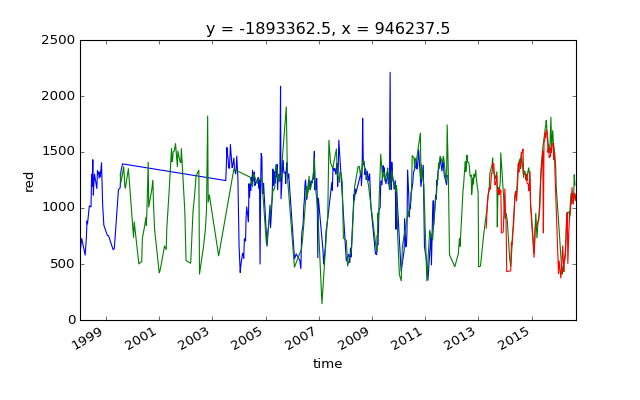

In [26]:
#plot a time series for each sensor
fig = plt.figure(figsize=(8,5))
red_ls5.plot()
red_ls7.plot()
red_ls8.plot()

In [27]:
#plot multi sensor time series
red_multi_sensor = nbar_clean.red.isel(x=[100],y=[100]).dropna('time', how = 'any')

<IPython.core.display.Javascript object>


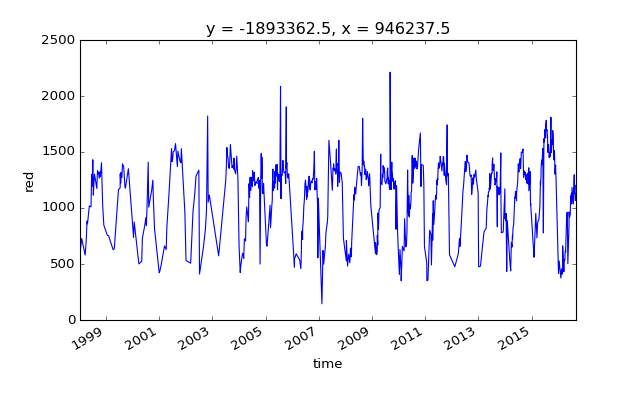

In [28]:
fig = plt.figure(figsize=(8,5))
red_multi_sensor.plot()